# Libraries 📖

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import squarify
import math
import plotly.graph_objects as go
import scipy.stats as stats

# Database 📂

In [2]:
conn = sqlite3.connect("../data/olist.sqlite")
c = conn.cursor()

In [3]:
# Average DF
query = """
SELECT
    rcr.RANK, 
	p.product_category_name,
    ROUND(Avg(julianday(o.order_delivered_customer_date)- julianday(o.order_approved_at)),0) AS avg_delivery_time,
    ROUND(AVG(gld.distance_km),0) AS avg_dist_km
FROM orders o
INNER JOIN order_items oi ON oi.order_id = o.order_id
INNER JOIN order_reviews or2 ON or2.order_id = o.order_id 
INNER JOIN geo_loc_det gld ON gld.order_id = o.order_id
INNER JOIN products p ON p.product_id = oi.product_id
INNER JOIN rev_cat_rank rcr ON rcr.product_category_name = p.product_category_name
WHERE o.order_status == 'delivered' AND 
p.product_category_name IS NOT NULL
GROUP BY p.product_category_name
ORDER BY rcr.RANK ;
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
df = pd.read_sql_query(query, conn)

In [4]:
# Top Features DF
query = """
SELECT
	MAX(oi.order_item_id) AS item_per_order,
	ROUND(julianday(o.order_delivered_customer_date)- julianday(o.order_approved_at),0) AS delivery_time,
	ROUND(gld.distance_km,0) AS dist_km,
	p.product_category_name,
	or2.review_score 
FROM orders o
INNER JOIN order_items oi ON oi.order_id = o.order_id
INNER JOIN order_reviews or2 ON or2.order_id = o.order_id 
INNER JOIN order_payments op ON op.order_id = o.order_id
INNER JOIN geo_loc_det gld ON gld.order_id = o.order_id
INNER JOIN products p ON p.product_id = oi.product_id 
WHERE o.order_status == 'delivered' AND 
p.product_category_name IS NOT NULL
GROUP BY oi.order_id
"""
c.execute(query)
c.fetchall()
df_tf = pd.read_sql_query(query, conn)

In [5]:
df_tf = df_tf.dropna()

In [6]:
# Category rank

query = """
SELECT *
FROM rev_cat_rank
"""
c.execute(query)
c.fetchall()
df_rank = pd.read_sql_query(query, conn)

# Analysis

## Data exploration

### Top Features

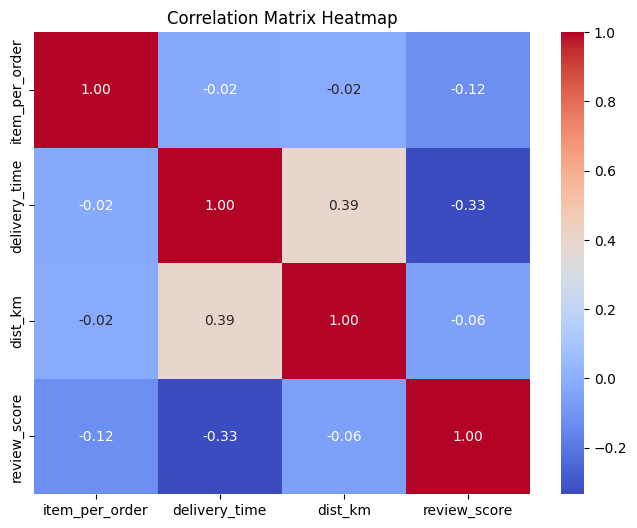

In [7]:
# Plotting the correlation matrix as a heatmap
correlation_matrix = df_tf.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

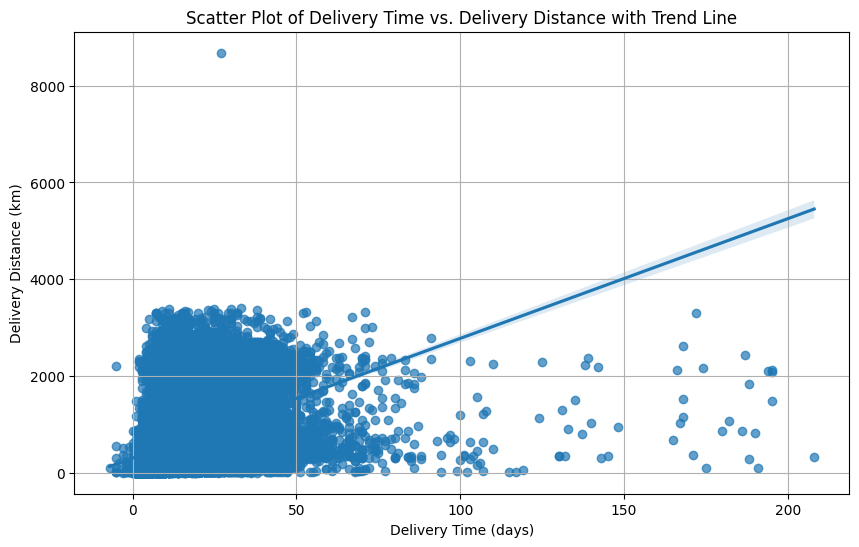

In [8]:
plt.figure(figsize=(10, 6))
sns.regplot(x='delivery_time', y='dist_km', data=df_tf, scatter_kws={'alpha':0.7})
plt.title("Scatter Plot of Delivery Time vs. Delivery Distance with Trend Line")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Delivery Distance (km)")
plt.grid(True)
plt.show()

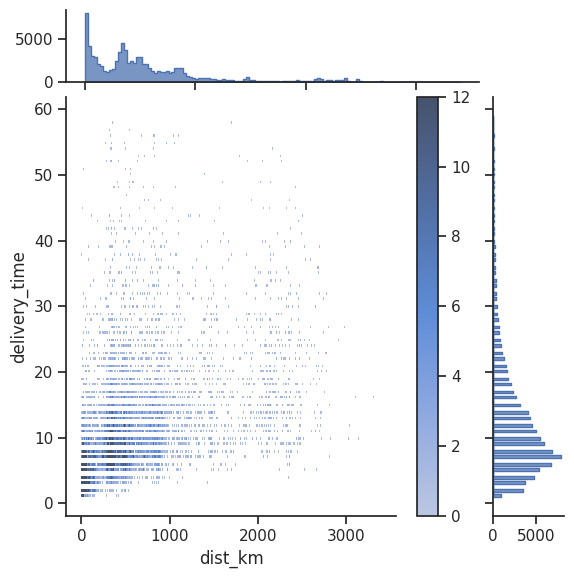

In [9]:
# cut outlier
df_tf_cut = df_tf[(df_tf['delivery_time']> 0) & (df_tf['delivery_time']< 60)]
df_tf_cut = df_tf_cut[(df_tf_cut['dist_km']> 0) & (df_tf_cut['dist_km']< 4000)]

sns.set_theme(style="ticks")

g = sns.JointGrid(data=df_tf_cut, x="dist_km", y="delivery_time", marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(True, False),
    pmax=.8, cbar=True
)
g.plot_marginals(sns.histplot, element="step")

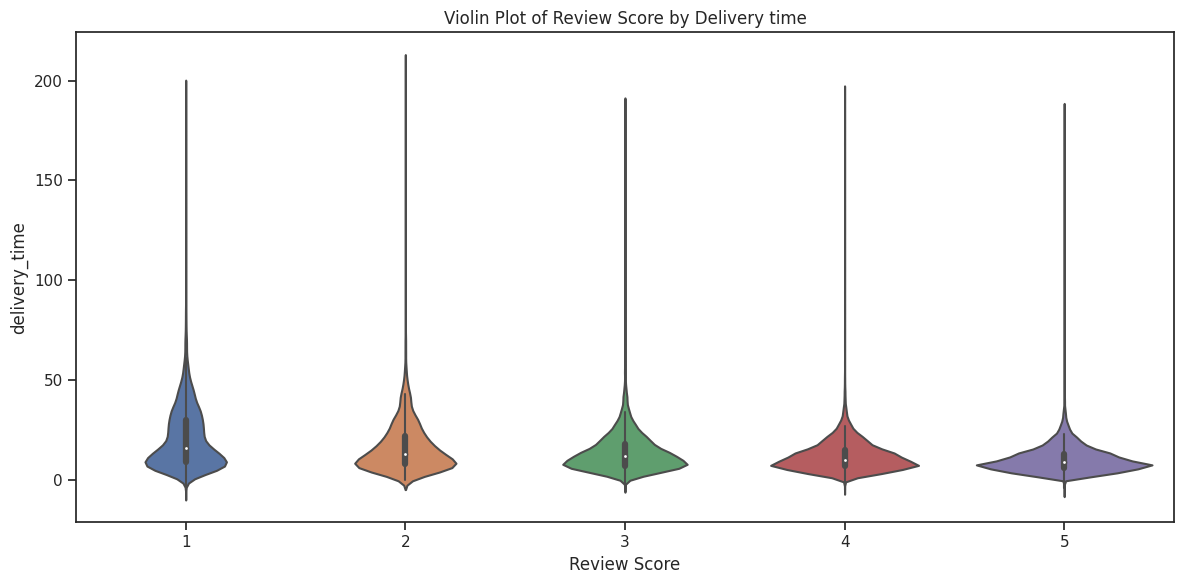

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(y="delivery_time", x="review_score", data=df_tf)
plt.title("Violin Plot of Review Score by Delivery time")
plt.ylabel("delivery_time")
plt.xlabel("Review Score")
plt.tight_layout()
plt.show()

## Delivery time

### TOP CAT

In [11]:
top20 = df_rank.head(20)

In [12]:
df_top_cat = df_tf[df_tf['product_category_name'].isin(top20['product_category_name'])]

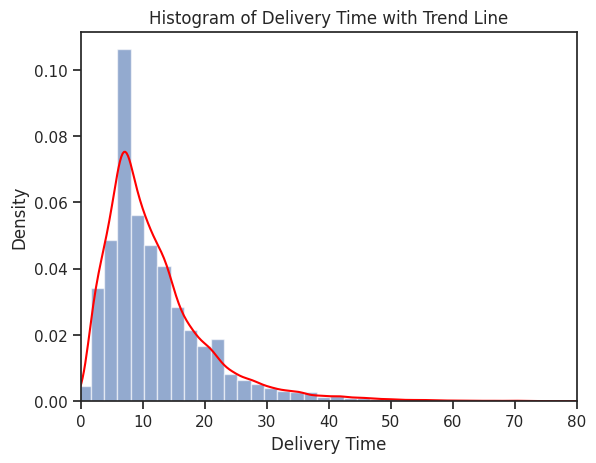

In [13]:
# Plot histogram with trend line for 'delivery_time' column
plt.hist(df_top_cat['delivery_time'], bins=100, density=True, alpha=0.6, color='b')

# Generate a trend line using Kernel Density Estimation for 'delivery_time'
kde = stats.gaussian_kde(df_top_cat['delivery_time'])
x_vals = np.linspace(df_top_cat['delivery_time'].min(), df_top_cat['delivery_time'].max(), 1000)
y_vals = kde(x_vals)

# Plot the trend line
plt.plot(x_vals, y_vals, color='red')
# Set x-axis limits
plt.xlim(0, 80)  # Adjust the range as needed

# Labels and title
plt.xlabel('Delivery Time')
plt.ylabel('Density')
plt.title('Histogram of Delivery Time with Trend Line')

# Show plot
plt.show()

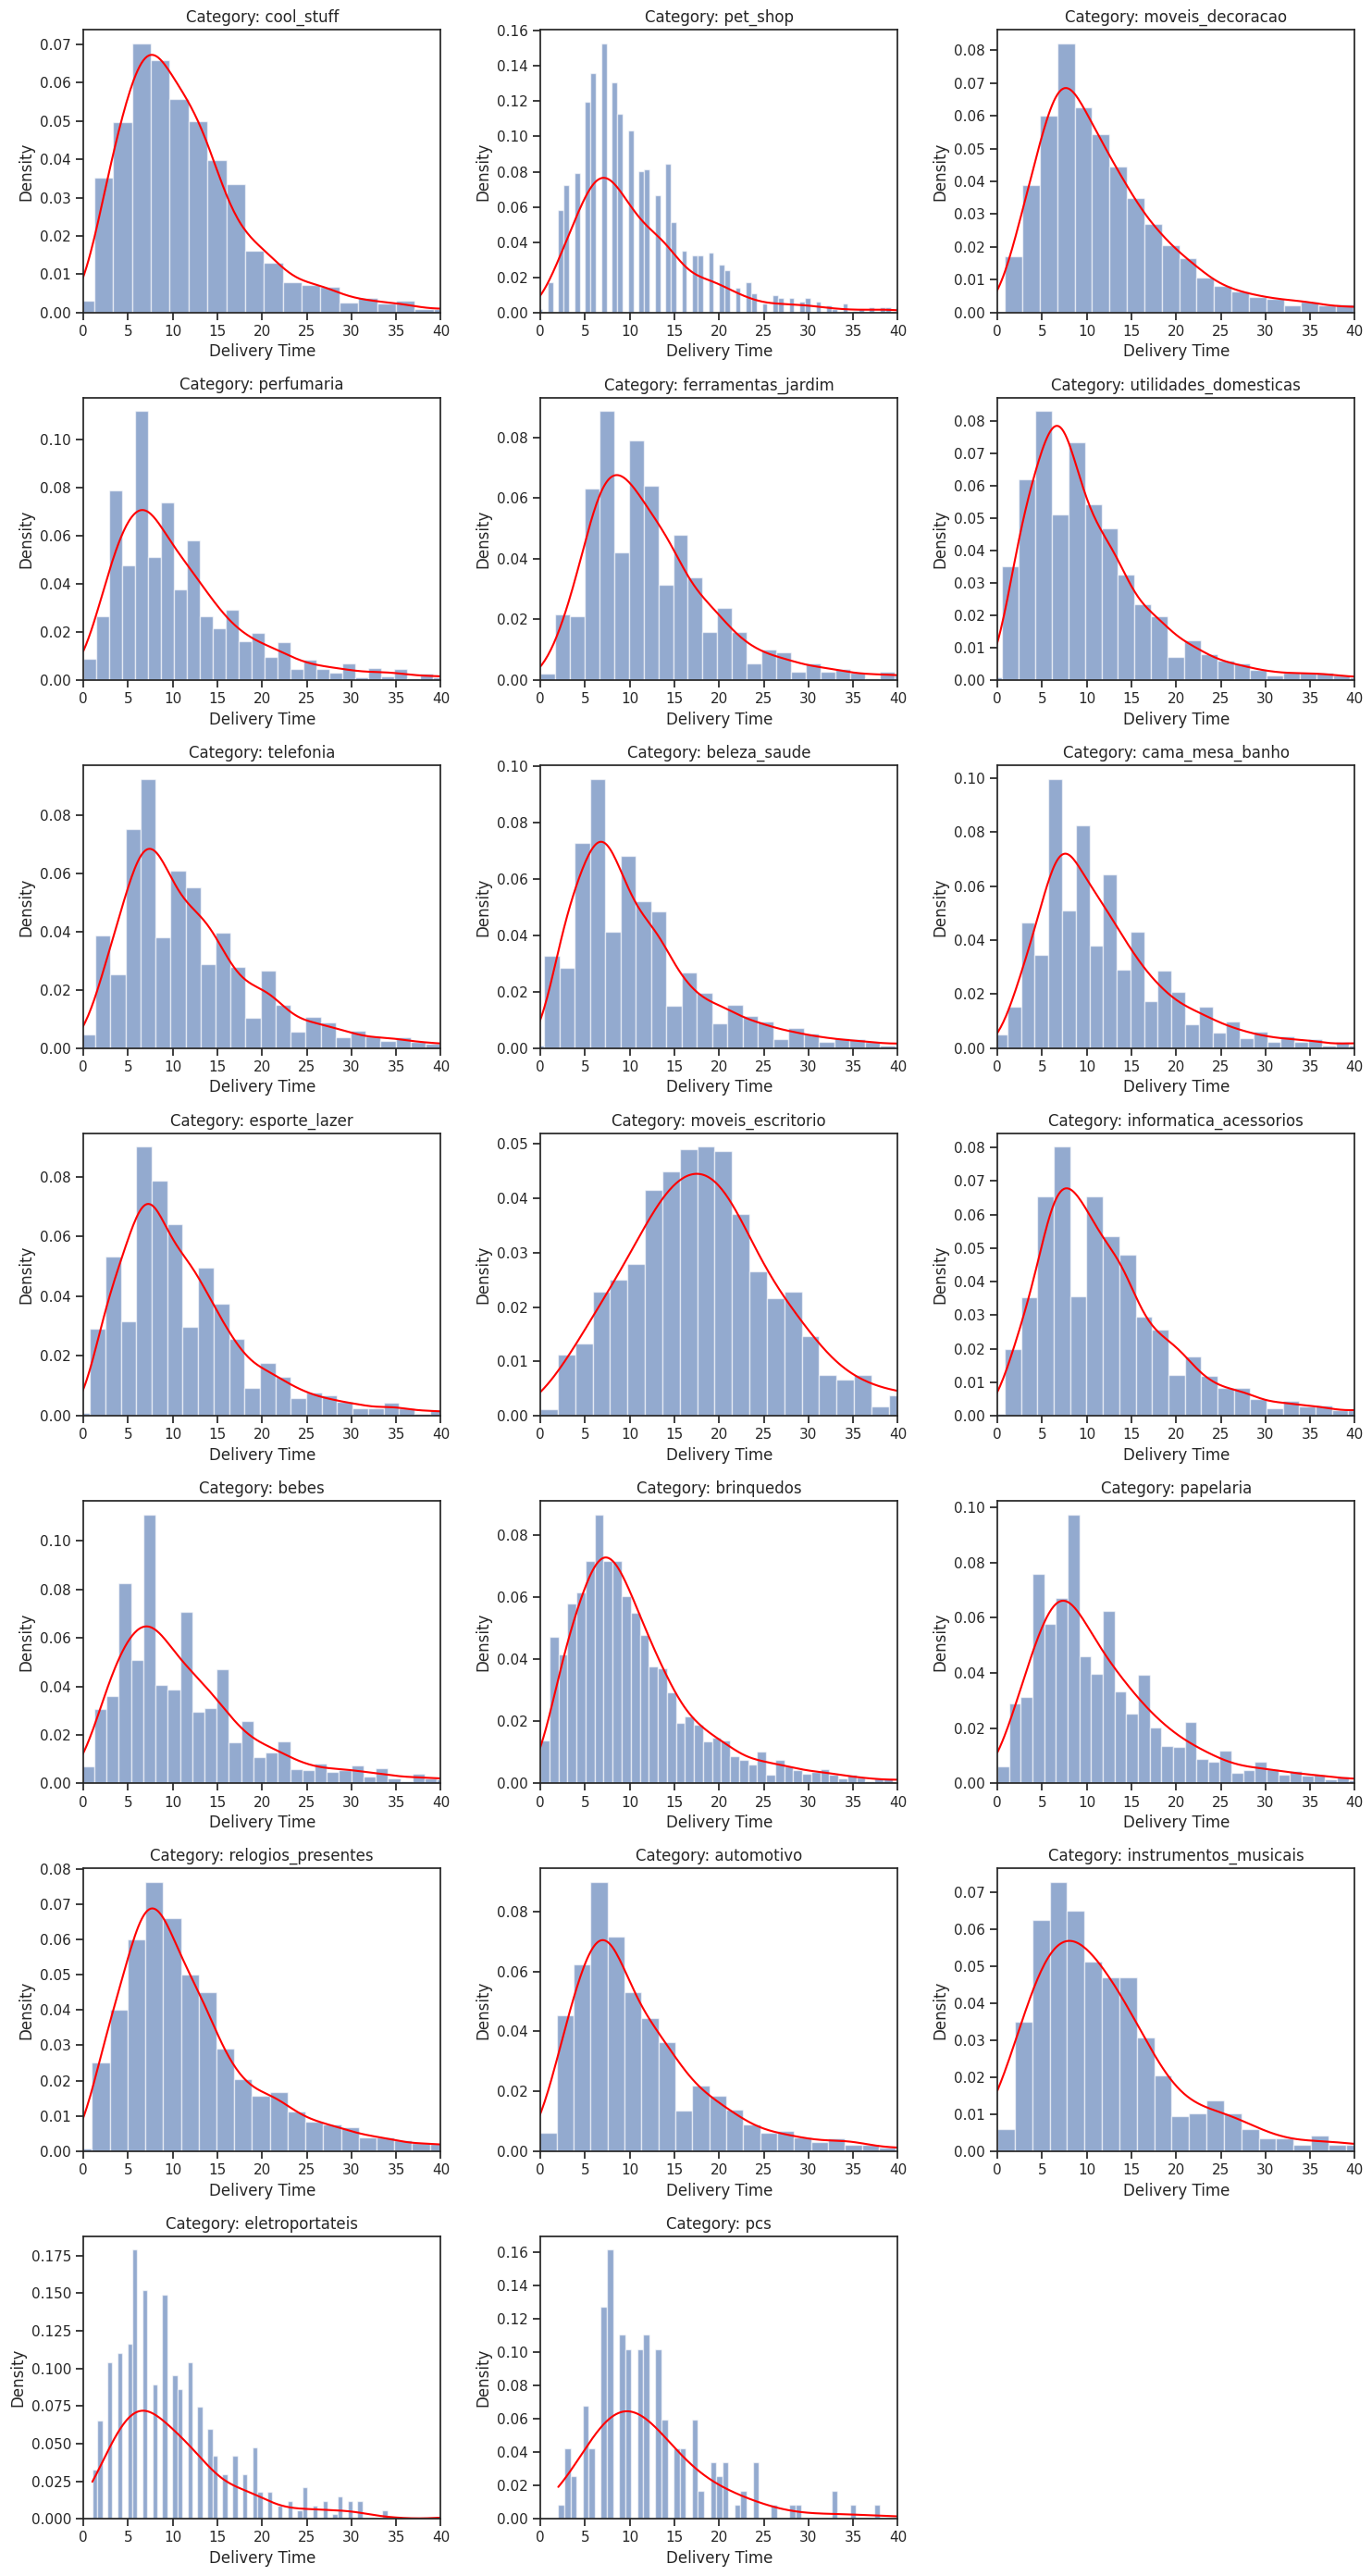

In [14]:
# Assuming `df` is your DataFrame with the data already loaded
# Get unique product categories
categories = df_top_cat['product_category_name'].unique()

# Define grid layout dimensions based on the number of categories
n_cols = 3  # Adjust the number of columns as needed
n_rows = (len(categories) + n_cols - 1) // n_cols  # Calculate the necessary number of rows

# Set up the figure for the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten to easily iterate through all axes

# Plot each category in its own subplot
for i, category in enumerate(categories):
    # Filter data for the specific category
    category_data = df_top_cat[df_top_cat['product_category_name'] == category]['delivery_time']
    
    # Plot histogram
    axes[i].hist(category_data, bins=100, density=True, alpha=0.6, color='b')
    
    # Trend line using KDE
    kde = stats.gaussian_kde(category_data)
    x_vals = np.linspace(category_data.min(), category_data.max(), 1000)
    y_vals = kde(x_vals)
    axes[i].plot(x_vals, y_vals, color='red')
    
    # Set title and labels for each subplot
    axes[i].set_title(f'Category: {category}')
    axes[i].set_xlabel('Delivery Time')
    axes[i].set_ylabel('Density')
    axes[i].set_xlim(0, 40)  # Adjust as needed for visibility

# Hide any empty subplots if categories don't fill the grid perfectly
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Delivery time vs impression

#### Encode review score and Split database positive / negative impression

In [15]:
df_tf_enc = df_tf.copy()

In [16]:
# Define rating_cat as customer satisfaction (1 for possitive, 0 negative)
def convert_score(valor):
    if valor < 4:
        return 0
    elif valor > 4:
        return 1
    
df_tf_enc['review_score'] = df_tf_enc['review_score'].apply(convert_score)
df_tf_enc['review_score'].value_counts()

1.0    55651
0.0    19833
Name: review_score, dtype: int64

In [17]:
df_tf_enc = df_tf_enc.dropna()
df_tf_enc = df_tf_enc.reset_index(drop=True)

In [18]:
df_tf_pos = df_tf_enc[df_tf_enc['review_score'] == 1].copy()
df_tf_neg = df_tf_enc[df_tf_enc['review_score'] == 0].copy()

In [19]:
df_tf_neg.drop(columns=['review_score'], inplace=True)
df_tf_pos.drop(columns=['review_score'], inplace=True)

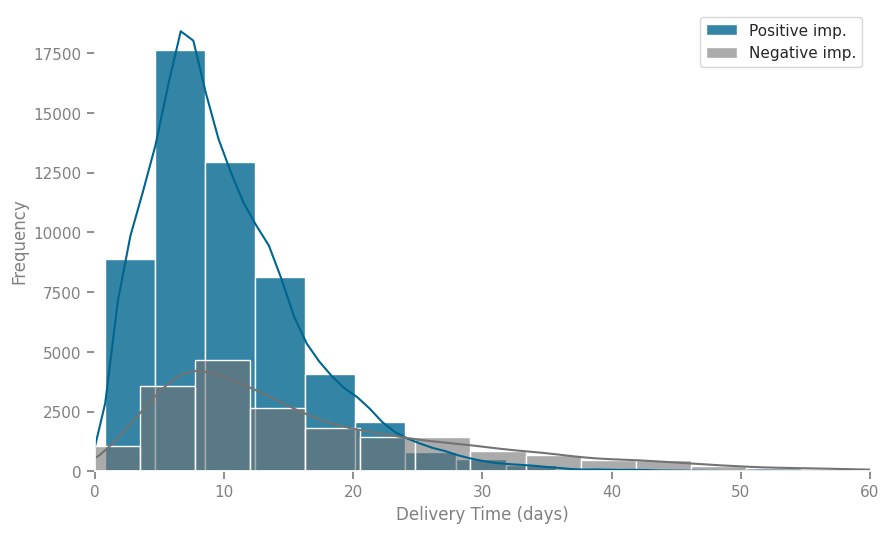

In [20]:
plt.figure(figsize=(10, 6))

# Plotting the first histogram with KDE
sns.histplot(df_tf_pos["delivery_time"], bins=50, kde=True, color='#00658f', edgecolor="white", label="Positive imp.", alpha=0.8)

# Plotting the second histogram with KDE on top of the first
sns.histplot(df_tf_neg["delivery_time"], bins=50, kde=True, color='#737373', edgecolor="white", label="Negative imp.", alpha=0.6)

# Setting the x-axis range
plt.xlim(0, 60)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis and y-axis color to grey
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

# Adding plot details
# plt.title("Overlayed Histograms of Delivery Times with KDE")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.legend()

# Save the plot with a high resolution (e.g., 300 DPI)
# plt.savefig("image1.png", dpi=300, bbox_inches="tight")

plt.show()

### Analysis of Positive Impressions

**SKEWNESS**

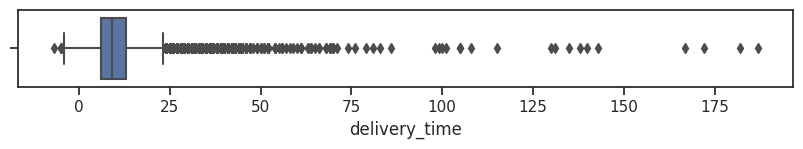

In [21]:
plt.figure(figsize=(10, 1))
df_tf_pos["delivery_time"].describe()
sns.boxplot(x=df_tf_pos["delivery_time"])
plt.show()

In [22]:
skewness_df_tf_pos = df_tf_pos["delivery_time"].skew()
skewness_df_tf_pos

3.5237189228471624

**MEAN, MEDIAN AND MODE**

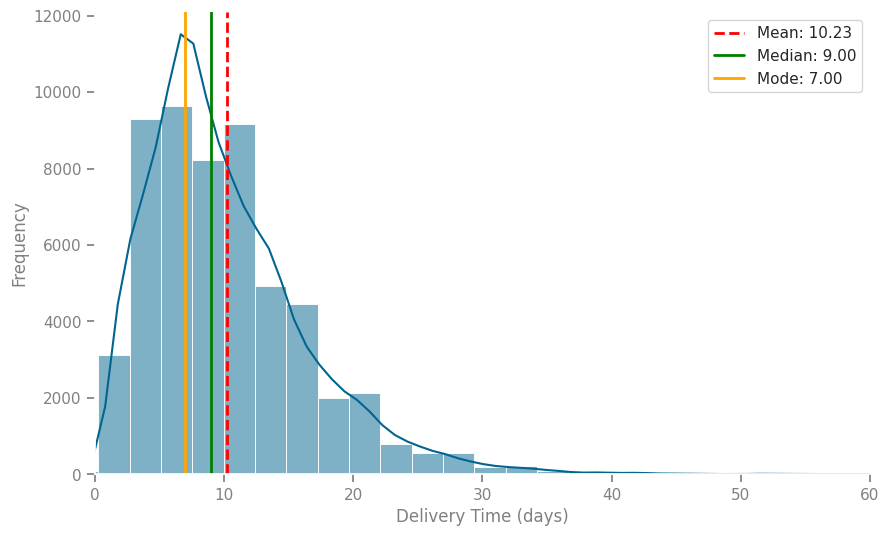

In [23]:
mean = df_tf_pos["delivery_time"].mean()
median = df_tf_pos["delivery_time"].median()
mode = df_tf_pos["delivery_time"].mode()[0]

# Plotting the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_tf_pos["delivery_time"], bins=80, kde=True,color='#00658f', edgecolor="white")

# Adding mean, median, and mode lines
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.2f}')

# Setting the x-axis range
plt.xlim(0, 60)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis and y-axis color to grey
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

# Adding plot details
# plt.title("Histogram of Delivery Times with KDE")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.legend()

# Save the plot with a high resolution (e.g., 300 DPI)
# plt.savefig("image2.png", dpi=300, bbox_inches="tight")

plt.show()

**VARIANCE**

In [24]:
pos_variance = df_tf_pos["delivery_time"].var()
pos_variance

45.94691138586173

**STANDARD DEVIATION**

In [25]:
pos_std_dev = df_tf_pos["delivery_time"].std()
pos_std_dev

6.778415108700686

**STANDARD ERROR**

In [26]:
# Calculate sample size
n = len(df_tf_pos["delivery_time"])

# Calculate standard error
pos_standard_error = pos_std_dev / np.sqrt(n)
print("Standard Error:", pos_standard_error)

Standard Error: 0.02873370807105669


**MEAN CONFIDENCE INTERVAL**

In [27]:
# Define confidence level (95%)
confidence_level = 0.95
degrees_freedom = n - 1
t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)

# Calculate the margin of error
margin_of_error = t_critical * pos_standard_error

# Confidence interval
confidence_interval = (mean - margin_of_error, mean + margin_of_error)
print("Confidence Interval:", confidence_interval)

Confidence Interval: (10.177226512224847, 10.28986302794514)


**MARGIN OF ERROR**

In [28]:
margin_of_error

0.05631825786014583

**Stats DF**

In [29]:
pos_stat_kpi = {"Impression": 1,
            "mean": mean,
            "median": median,
            "mode": mode,
            "n": n,
            "variance": pos_variance,
            "std_dev": pos_std_dev
           }
pos_stat_kpi_df = pd.DataFrame([pos_stat_kpi])
pos_stat_kpi_df

,Impression,mean,median,mode,n,variance,std_dev
0,1,10.233545,9.0,7.0,55651,45.946911,6.778415


### Analysis of Negative Impressions

**SKEWNESS**

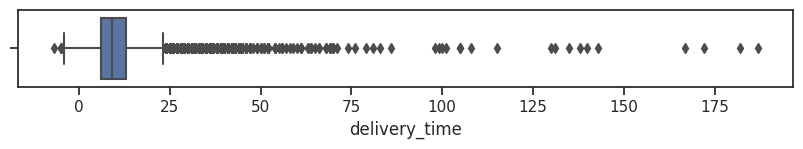

In [30]:
plt.figure(figsize=(10, 1))
df_tf_neg["delivery_time"].describe()
sns.boxplot(x=df_tf_pos["delivery_time"])
plt.show()

In [31]:
skewness_df_tf_neg = df_tf_neg["delivery_time"].skew()
skewness_df_tf_neg

2.598833903260978

**MEAN, MEDIAN AND MODE**

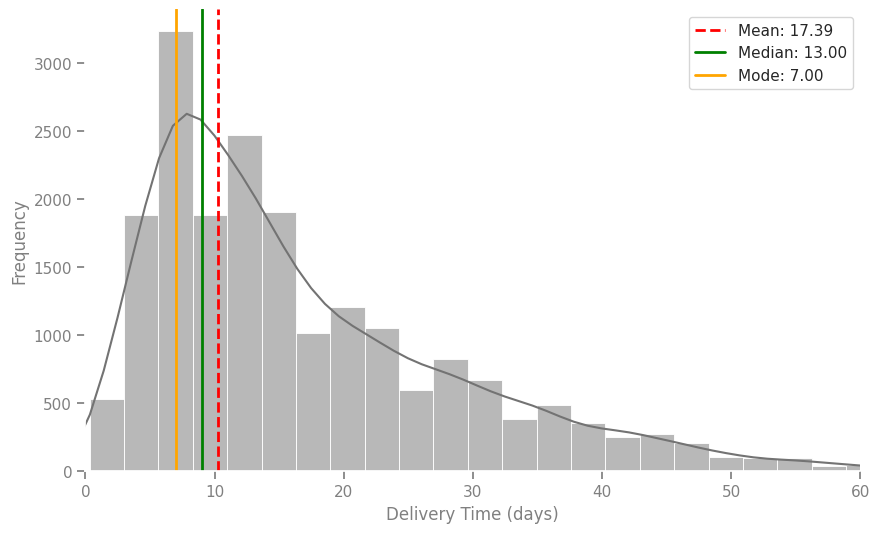

In [32]:
mean2 = df_tf_neg["delivery_time"].mean()
median2 = df_tf_neg["delivery_time"].median()
mode2 = df_tf_neg["delivery_time"].mode()[0]

# Plotting the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_tf_neg["delivery_time"], bins=80, kde=True, edgecolor="white", color='#737373')

# Adding mean, median, and mode lines
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean2:.2f}')
plt.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median2:.2f}')
plt.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode2:.2f}')

# Setting the x-axis range
plt.xlim(0, 60)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis and y-axis color to grey
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

# Adding plot details
# plt.title("Histogram of Delivery Times with KDE")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.legend()

# Save the plot with a high resolution (e.g., 300 DPI)
# plt.savefig("image3.png", dpi=300, bbox_inches="tight")

plt.show()

In [33]:
neg_stat = {"mean": mean2,"median": median2,"mode": mode2}
neg_stat_df = pd.DataFrame([neg_stat])
neg_stat_df

,mean,median,mode
0,17.394494,13.0,7.0


**VARIANCE**

In [34]:
neg_variance = df_tf_neg["delivery_time"].var()
neg_variance

190.87088940840772

**STANDARD DEVIATION**

In [35]:
neg_std_dev = df_tf_neg["delivery_time"].std()
neg_std_dev

13.81560311417521

**STANDARD ERROR**

In [36]:
# Calculate sample size
n2 = len(df_tf_neg["delivery_time"])

# Calculate standard error
neg_standard_error = neg_std_dev / np.sqrt(n2)
print("Negative Standard Error:", neg_standard_error)

Negative Standard Error: 0.09810149881321832


**MEAN CONFIDENCE INTERVAL**

In [37]:
# Define confidence level (95%)
confidence_level = 0.95
degrees_freedom = n2 - 1
t_critical2 = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)

# Calculate the margin of error
margin_of_error2 = t_critical2 * neg_standard_error

# Confidence interval
confidence_interval2 = (mean2 - margin_of_error2, mean2 + margin_of_error2)
print("Confidence Interval:", confidence_interval2)

Confidence Interval: (17.20220688516234, 17.58678116505699)


**MARGIN OF ERROR**

In [38]:
margin_of_error2

0.1922871399473249

**Stats DF**

In [39]:
neg_stat_kpi = {"Impression": 0,
            "mean": mean2,
            "median": median2,
            "mode": mode2,
            "n": n2,
            "variance": neg_variance,
            "std_dev": neg_std_dev
           }
neg_stat_kpi_df = pd.DataFrame([neg_stat_kpi])
neg_stat_kpi_df

,Impression,mean,median,mode,n,variance,std_dev
0,0,17.394494,13.0,7.0,19833,190.870889,13.815603


### Analysis of Impressions

In [40]:
stat_kpi_df = pd.concat([pos_stat_kpi_df, neg_stat_kpi_df])
stat_kpi_df.reset_index(inplace=True)

In [41]:
stat_kpi_df

,index,Impression,mean,median,mode,n,variance,std_dev
0,0,1,10.233545,9.0,7.0,55651,45.946911,6.778415
1,0,0,17.394494,13.0,7.0,19833,190.870889,13.815603


**Pooled variance**

In [42]:
pv = sum((stat_kpi_df['n']-1)*stat_kpi_df['variance'])/(sum(stat_kpi_df['n'])-2)
pv

84.02396726863023

In [43]:
# Define confidence level (95%)
confidence_level = 0.95
degrees_freedom2 = sum(stat_kpi_df['n'])-2
t_critical2 = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom2)

**Margin of error**

In [44]:
me = t_critical2*np.sqrt(pv/stat_kpi_df['variance'][0]+pv/stat_kpi_df['variance'][1])
me

2.9523361788506843

In [45]:
d_mean = stat_kpi_df['mean'][0]-stat_kpi_df['mean'][1]
-d_mean

7.160949255024672

**Confidence Interval 95%**

In [46]:
confidence_interval = [d_mean - me, d_mean + me ]
confidence_interval

[-10.113285433875356, -4.208613076173988]

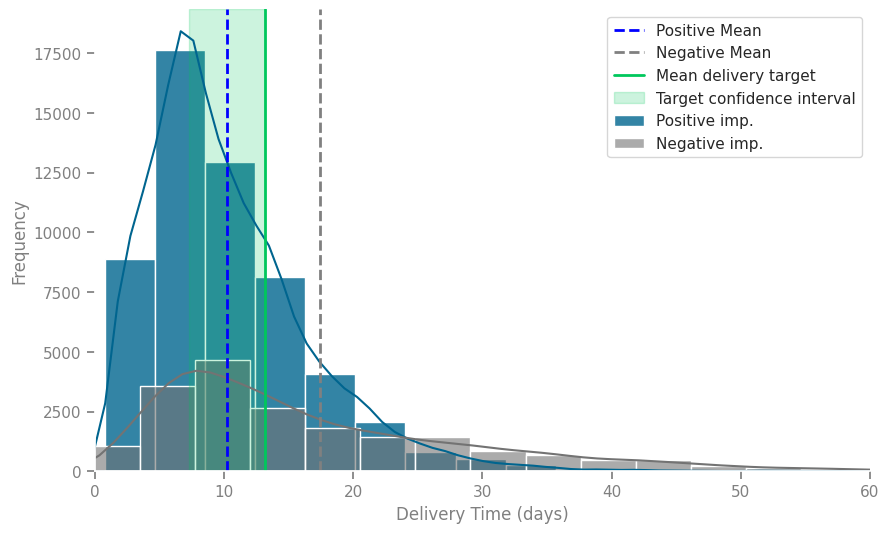

In [47]:
# Plotting the histograms with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_tf_pos["delivery_time"], bins=50, kde=True, color='#00658f', edgecolor="white", label="Positive imp.", alpha=0.8)
sns.histplot(df_tf_neg["delivery_time"], bins=50, kde=True, color='#737373', edgecolor="white", label="Negative imp.", alpha=0.6)

# Setting the x-axis range
plt.xlim(0, 60)

# Plotting the mean lines
plt.axvline(mean, color='blue', linestyle='--', linewidth=2, label=f'Positive Mean')
plt.axvline(mean2, color='gray', linestyle='--', linewidth=2, label=f'Negative Mean')


# Adding the line at Mean delivery targe
plt.axvline(mean + me, color='#00c75c', linestyle='-', linewidth=2, label='Mean delivery target')


# Highlighting the specified area
plt.axvspan(mean - me, mean + me, color='#00c75c', alpha=0.2, label='Target confidence interval')

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis and y-axis color to grey
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')


# Adding plot details
# plt.title("Overlayed Histograms of Delivery Times with Means and Confidence Intervals")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.legend()

# Save the plot with a high resolution (e.g., 300 DPI)
# plt.savefig("image4.png", dpi=300, bbox_inches="tight")

plt.show()